# Will the bank customers leave soon?
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

Our task is to predict whether a customer will leave the bank soon. The data on clients’ past behavior and termination of contracts with the bank has been provided.

We will analyze the provided data, try to build model with highest possible F1 score (minimum requiored F1 is 0.59). For this we will follow these steps:

- Load/Preprocess and Explore data;
- Build model with raw (class imbalance) data;
- Fix the class imbalance and improve the quality of the model;
- Final testing of the tuned model.

Each and every step will contain a preliminary conclusion about the finding/outcomes of the performed tasks. For the tuned model in the last step, the AUC-ROC metric will be compared with the F1 score.

## Load/Preprocess data
In this step, necessary Python libraries and data will be loaded. Then the data will be explored for any missing values, duplicates, data type errors and will be fixed giving appropriate explanations. In the end, columns that contain string will be handled to make them numerical.

In [1]:
# necessary Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data and explore
df=pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# size of data
df.shape

(10000, 14)

In [4]:
#convert column names to lowercase
df.columns=df.columns.str.lower()

#check the result
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [5]:
#function that check number of missing values and their percentages in each column
def missing_data(df):
    col_names=df.columns.tolist()
    na_per_col=df.isna().sum().tolist()
    na_percentage=(df.isna().sum()/len(df)*100).tolist()
    return pd.DataFrame((na_per_col, na_percentage), index=['Number of missings', '% of missings'], columns=col_names)\
.style.background_gradient(axis=1)

#apply the function
missing_data(df)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
Number of missings,0,0,0,0,0,0,0,909,0,0,0,0,0,0
% of missings,0,0,0,0,0,0,0,9.09,0,0,0,0,0,0


In [6]:
#fill missing values
df['tenure']=df['tenure'].ffill(axis=0)

#check the result
df.tenure.isna().sum()

0

In [7]:
#check for duplicated rows
df.duplicated().sum()

0

In [8]:
#drop unnecessary columns
df=df.drop(['rownumber', 'customerid', 'surname'], axis=1)

#check the result
df.head(2)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


In [9]:
#check the correlation between columns
df.corr().round(2).style.background_gradient()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
creditscore,1,-0,-0,0.01,0.01,-0.01,0.03,-0,-0.03
age,-0,1,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
tenure,-0,-0.01,1,-0.01,0.01,0.02,-0.03,0.01,-0.02
balance,0.01,0.03,-0.01,1,-0.3,-0.01,-0.01,0.01,0.12
numofproducts,0.01,-0.03,0.01,-0.3,1,0,0.01,0.01,-0.05
hascrcard,-0.01,-0.01,0.02,-0.01,0,1,-0.01,-0.01,-0.01
isactivemember,0.03,0.09,-0.03,-0.01,0.01,-0.01,1,-0.01,-0.16
estimatedsalary,-0,-0.01,0.01,0.01,0.01,-0.01,-0.01,1,0.01
exited,-0.03,0.29,-0.02,0.12,-0.05,-0.01,-0.16,0.01,1


In [10]:
#check for data typesof columns
df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [11]:
#encode categorical columns using Onehotencoding method, this data will be used for LogisticRegression model
df_ohe=pd.get_dummies(df, drop_first=True)

#check the result
df_ohe.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0


In [12]:
#encode categorical columns using LabelEncoding method, this data will be used for DecisionTree and RandomForest models
encoder=OrdinalEncoder()
df_ord=pd.DataFrame(encoder.fit_transform(df), columns=df.columns)
df_ord.head(2)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0


In [13]:
# a function that splits provided data into features and target, then splits them into training, validation and testing
#finally applies scaling to provided numerical columns
def train_valid_test_splitter(df, target_col, numeric):
    '''splits data into features and target, then split them into training,
    validation and testing datasets with 06:0.2:0.2 ratios'''
    features=df.drop(target_col, axis=1)
    target=df[target_col]
    #split features

    features_train, features_rest = train_test_split(features, test_size=0.4, random_state=234)
    # divide rest into two parts to get validation and test datasets
    features_valid, features_test = train_test_split(features_rest, test_size=0.5, random_state=234)
    
    #split target

    target_train, target_rest = train_test_split(target, test_size=0.4, random_state=234)
    # now divide rest into two parts to get validation and test datasets
    target_valid, target_test = train_test_split(target_rest, test_size=0.5, random_state=234)
    
    scaler=StandardScaler()
    features_train[numeric]=scaler.fit_transform(features_train[numeric])
    features_valid[numeric]=scaler.transform(features_valid[numeric])
    features_test[numeric]=scaler.transform(features_test[numeric])
    return (features_train, features_valid, features_test, target_train, target_valid, target_test)

In [14]:
#prepare feature and target sets from onehotencoded df
features_ohe_train, features_ohe_valid, features_ohe_test, target_ohe_train, target_ohe_valid, target_ohe_test =\
train_valid_test_splitter(df=df_ohe, target_col='exited', numeric=['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary'])

#check the result
features_ohe_train.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
4276,0.191645,-0.649963,-0.346201,0.433065,2,0,1,0.610819,1,0,0
2101,0.274764,0.965993,1.031257,-1.216818,2,0,1,-0.030257,0,1,0


In [15]:
#prepare feature and target sets from Labelencoded df
features_ord_train, features_ord_valid, features_ord_test, target_ord_train, target_ord_valid, target_ord_test =\
train_valid_test_splitter(df=df_ohe, target_col='exited', numeric=['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary'])

#check the result
features_ord_train.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
4276,0.191645,-0.649963,-0.346201,0.433065,2,0,1,0.610819,1,0,0
2101,0.274764,0.965993,1.031257,-1.216818,2,0,1,-0.030257,0,1,0


### Conclusion
The data, containing 10000 rows and 14 columns, has been loaded. For convenience, all columns names were converted to lowercase.

The 9% values were missing in the `Tenure` column. The most probable reason for the missing values might be that these customers never reached maturation or due to technical reasons the values were not inputted. To prevent loss of data, missing values filled using the 'forward fill' method, where missing values were filled with the last observed value. 

Not any duplicated rows were observed. 

`RowNumber, CustomerId, Surname` columns have been dropped out because they would not add any values for the classification model. 

Correlations between columns were weak in general. Only `age and exited` columns have a correlation of 0.29 and `numofproducts and balance` columns have a correlation of -0.3. 

Then columns containing `string` values have been encoded with the OneHotEncoding for LogisticRegression model and LabelEncoding for DecisionTree and RandomForest models. 

Finally, the whole dataset has been splitter into training, validation and testing datasets with 0.6:0.2:0.2 ratios and columns containing numerical values have been scaled.

## Train models with raw data
Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.

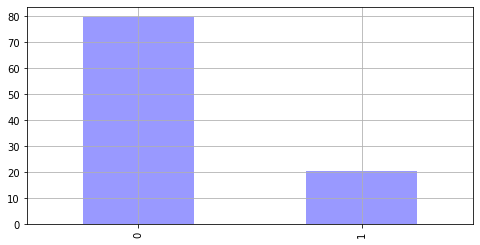

In [16]:
# check for the balance of class in the target column
df['exited'].value_counts(normalize=True).mul(100).plot(kind='bar', figsize=(8, 4), grid=True, alpha=0.4, color='blue')
plt.show()

### DecisionTreeClassifier
Train a DecisionTreeClassifier model with the data and check the F1 score for different tree depth values.

In [17]:
#loop to check f1 score at different max_depth values
depth=[]
f1=[]
for i in range(2, 20):
    dt_model=DecisionTreeClassifier(max_depth=i, random_state=234)
    dt_model.fit(features_ord_train, target_ord_train)
    predicted=dt_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)
    
#visualize the result
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient( axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.51,0.409,0.532,0.553,0.564,0.565,0.558,0.552,0.538,0.528,0.507,0.506,0.502,0.496,0.501,0.498,0.503,0.502


### RandomForestClassifier
Train a RandomForestClassifier model with the data and check the F1 score for different number of trees and tree depth values.

In [18]:
#find out f1 scores for different number of trees
tree=[]
f1=[]
for i in range(0, 150, 10):
    if i !=0:
        rf_model=RandomForestClassifier(n_estimators=i, random_state=234)
        rf_model.fit(features_ord_train, target_ord_train)
        predicted=rf_model.predict(features_ord_valid)
        f1.append(f1_score(target_ord_valid, predicted))
        tree.append(i)

#visualize the result
pd.DataFrame([f1], index=['f1_score'], columns=tree).round(3).style.background_gradient(axis=1)

,10,20,30,40,50,60,70,80,90,100,110,120,130,140
f1_score,0.551,0.568,0.581,0.588,0.597,0.596,0.598,0.596,0.592,0.593,0.593,0.592,0.591,0.591


In [19]:
#find out f1 scores for different depth of trees using optimal n_estimator values from previous step
depth=[]
f1=[]
for i in range(2, 20):
    rf_model=RandomForestClassifier(n_estimators=70, max_depth=i, random_state=234)
    rf_model.fit(features_ord_train, target_ord_train)
    predicted=rf_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)

#visualize the result
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient(axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.114,0.294,0.427,0.518,0.554,0.568,0.591,0.578,0.59,0.595,0.588,0.604,0.589,0.606,0.605,0.605,0.612,0.599


### LogisticRegression
Train a LogisticRegression model with the data and check the F1 score.

In [20]:
#LogisticRegerssion model and its F1 score
lg_model=LogisticRegression(random_state=234, solver='liblinear')
lg_model.fit(features_ohe_train, target_ohe_train)
predicted=lg_model.predict(features_ohe_valid)
print('F1 socre of the logsitic regression model is', round(f1_score(target_ohe_valid, predicted), 3))

F1 socre of the logsitic regression model is 0.34


### Conclusion
The provided data was not balanced, where the percentage of customers who left the bank was around 20%. Three different models have been tested using the raw or imbalanced data, hyperparameters are tuned where applicable.
Optimal F1 scores have been obtained as follow for each model:
- **DecisionTree => 0.565** with tree depth of 7;
- **RandomForest => 0.606** with forest size of 70 and tree depth of 15;
- **LogisticRegression => 0.340**. 

## Fix the class imbalance
In this section, we will try to improve the quality of models by fixing balance issue of our data. Following two approaches will be used to fix data imbalance:
- **Class_weight adjustment**
- **Upsampling**

For each approached we will check and compare the F1 score of previous three different models.

### Class weight adjustment
Machine learning algorithms consider all observations in the training set to be equally weighted by default. If we need to indicate that some observations are more important, we assign a weight to the respective class using `class_weight` argument.

#### DecisionTree with balanced class_weight

In [21]:
#loop to check f1 score at different max_depth values
depth=[]
f1=[]
for i in range(2, 20):
    dt_model=DecisionTreeClassifier(max_depth=i, random_state=234, class_weight='balanced')
    dt_model.fit(features_ord_train, target_ord_train)
    predicted=dt_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)
    
#visualize the result    
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient( axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.531,0.531,0.509,0.586,0.549,0.57,0.547,0.55,0.536,0.528,0.521,0.506,0.504,0.499,0.502,0.499,0.509,0.499


#### RandomForest with balanced class_weight

In [22]:
#find out f1 scores for different number of trees
tree=[]
f1=[]
for i in range(0, 150, 10):
    if i !=0:
        rf_model=RandomForestClassifier(n_estimators=i, random_state=234, class_weight='balanced')
        rf_model.fit(features_ord_train, target_ord_train)
        predicted=rf_model.predict(features_ord_valid)
        f1.append(f1_score(target_ord_valid, predicted))
        tree.append(i)

#visualize the result  
pd.DataFrame([f1], index=['f1_score'], columns=tree).round(3).style.background_gradient(axis=1)

,10,20,30,40,50,60,70,80,90,100,110,120,130,140
f1_score,0.531,0.569,0.573,0.578,0.578,0.586,0.582,0.581,0.59,0.591,0.597,0.599,0.599,0.596


In [23]:
#find out f1 scores for different depth of trees using optimal n_estimator values from previous step
depth=[]
f1=[]
for i in range(2, 20):
    rf_model=RandomForestClassifier(max_depth=i, n_estimators=120,  random_state=234, class_weight='balanced')
    rf_model.fit(features_ord_train, target_ord_train)
    predicted=rf_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)

#visualize the result      
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient(axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.57,0.58,0.587,0.591,0.6,0.617,0.614,0.632,0.626,0.62,0.62,0.605,0.608,0.601,0.603,0.599,0.591,0.605


#### LogisticRegression with balanced class_weight

In [24]:
#LogisticRegerssion model and its F1 score
lg_model=LogisticRegression(random_state=234, solver='liblinear', class_weight='balanced')
lg_model.fit(features_ohe_train, target_ohe_train)
predicted=lg_model.predict(features_ohe_valid)
print('F1 socre of the logsitic regression model is', round(f1_score(target_ohe_valid, predicted), 3))

F1 socre of the logsitic regression model is 0.481


### Upsampling
Upsampling is performed in several steps:
    Split the training sample into negative and positive observations;
    Duplicate the positive observations several times;
    Create a new training sample based on the data obtained;
    Shuffle the data: identical questions following one another will not help the training.

In [25]:
#function that upsample provided datasets
def upsample(features, target, ups):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * ups)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * ups)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=234)

    return features_upsampled, target_upsampled


#apply the function to LabelEncoded and OneHotEncoded training datasets
features_ord_train_ups, target_ord_train_ups = upsample(features_ord_train, target_ord_train, 4)
features_ohe_train_ups, target_ohe_train_ups = upsample(features_ohe_train, target_ohe_train, 4)

#### DecisionTree with upsampling

In [26]:
#loop to check f1 score at different max_depth values
depth=[]
f1=[]
for i in range(2, 20):
    dt_model=DecisionTreeClassifier(max_depth=i, random_state=234)
    dt_model.fit(features_ord_train_ups, target_ord_train_ups)
    predicted=dt_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)

#visualize the result     
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient( axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.531,0.531,0.509,0.586,0.549,0.57,0.546,0.547,0.536,0.53,0.522,0.507,0.509,0.507,0.485,0.505,0.507,0.499


#### RandomForest with upsampling

In [27]:
#find out f1 scores for different number of trees
tree=[]
f1=[]
for i in range(0, 150, 10):
    if i !=0:
        rf_model=RandomForestClassifier(n_estimators=i, random_state=234)
        rf_model.fit(features_ord_train_ups, target_ord_train_ups)
        predicted=rf_model.predict(features_ord_valid)
        f1.append(f1_score(target_ord_valid, predicted))
        tree.append(i)

#visualize the result 
pd.DataFrame([f1], index=['f1_score'], columns=tree).round(3).style.background_gradient(axis=1)

,10,20,30,40,50,60,70,80,90,100,110,120,130,140
f1_score,0.582,0.613,0.613,0.611,0.597,0.598,0.608,0.607,0.608,0.608,0.609,0.613,0.611,0.61


In [28]:
#find out f1 scores for different depth of trees using optimal n_estimator values from previous step
depth=[]
f1=[]
for i in range(2, 20):
    rf_model=RandomForestClassifier(max_depth=i, n_estimators=120,  random_state=234)
    rf_model.fit(features_ord_train_ups, target_ord_train_ups)
    predicted=rf_model.predict(features_ord_valid)
    f1.append(f1_score(target_ord_valid, predicted))
    depth.append(i)

#visualize the result 
pd.DataFrame([f1], index=['f1_score'], columns=depth).round(3).style.background_gradient(axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.573,0.577,0.589,0.584,0.601,0.61,0.612,0.616,0.614,0.626,0.629,0.634,0.633,0.617,0.634,0.63,0.628,0.628


#### LogisticRefgression with upsampling

In [29]:
#LogisticRegerssion model and its F1 score
lg_model=LogisticRegression(random_state=234, solver='liblinear')
lg_model.fit(features_ohe_train_ups, target_ohe_train_ups)
predicted=lg_model.predict(features_ohe_valid)
print('F1 socre of the logsitic regression model is', round(f1_score(target_ohe_valid, predicted), 3))

F1 socre of the logsitic regression model is 0.48


### Conclusion
Data has been balanced using two different approaches: i) Class_weigth adjustment; ii) Upsampling. Following F1 score values has been obtained:

|Approach|DecisionTree|RandomForest|LogisticRegression|
|--------|------------|------------|------------------|
|Class_weight|0.586|0.632|0.481|
|Upsampling|0.586|0.634|0.480|

**The highest F1 score of 0.634 has been obtained with RandomForest model** with upsampling approach (forest size=120, tree depth=13)

## Final testing
RandomForestClassifier performed significantly better than DecisionTree and LogisticRegression models. In this section, we will train a RandomForestClassifier, balance classes using Upsampling approach and test its performance with our testing data set. 

More the data, the higher the accuracy of the model. Therefore, here we decided to combine our previous training and validation datasets to make more data for training our model.

In [30]:
#add up previous training and validation datasets
features_more=pd.concat([features_ord_train, features_ord_valid])
target_more=pd.concat([target_ord_train, target_ord_valid])

#use the upsampling function from the previous section to increase the number of positive observations in training datasets
features_more_ups, target_more_ups = upsample(features_more, target_more, 4)


#create a model, choose hyperparameters based on the previous section
final_model=RandomForestClassifier(n_estimators=120, max_depth=13, random_state=234)

#train the model
final_model.fit(features_more_ups, target_more_ups)

#predict answers for testing dataset
predicted_test=final_model.predict(features_ord_test)

#print the F1 score
print('F1 score of the final model with testing dataset is', round(f1_score(target_ord_test, predicted_test), 3))
print('The final model has an accuracy of', final_model.score(features_ord_test, target_ord_test))

F1 score of the final model with testing dataset is 0.604
The final model has an accuracy of 0.8315


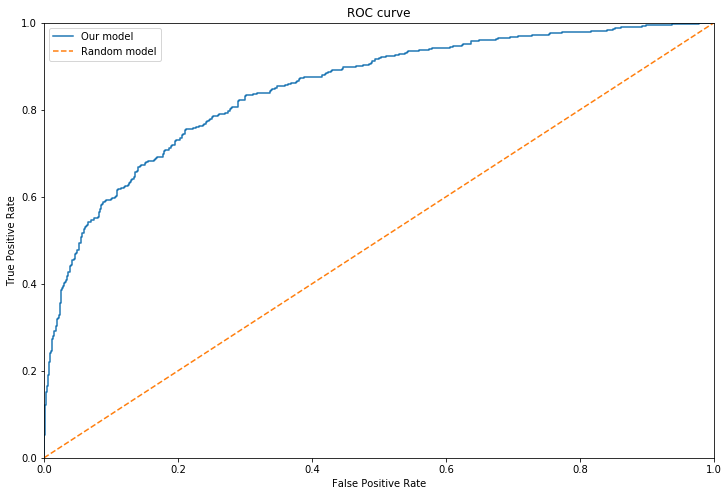

AUC-ROC score of the final model with testing dataset is 0.848


In [31]:
# create a random model 
prob_test=final_model.predict_proba(features_ord_test)    #Find class probability
prob_test_ones=prob_test[:, 1] #select probability of 

#find false positive and true positive rates
fpr, tpr, thresholds = roc_curve(target_ord_test, prob_test_ones)

#visualize FPR vs TPR values of the RandomForestModel and random model
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label='Our model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')
plt.show()


#print our area under curve values
print('AUC-ROC score of the final model with testing dataset is', round(roc_auc_score(target_ord_test, prob_test_ones), 3))

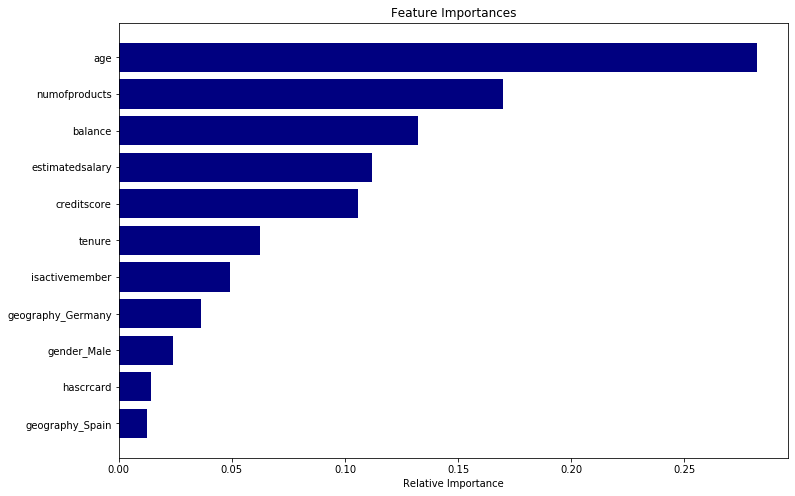

In [32]:
#plot a curve showing the relative importance of each feature on the model
features=features_ord_train.columns.tolist()
importances=final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Conclusion
The final model has an **F1 score of 0.604** with the testing dataset. And its **AUC-ROC values is 0.848**, which is close to 1 (perfect model).

In a summary, we can say that the built model can predict customers who will leave the bank with an **accuracy of 83.15%**. Age of customers was the most influencing factor on leaving the bank.

## Summary

- The data, containing 10000 rows and 14 columns, has been utilized to build a model that predicts whether the customer likely to leave the bank.
- There was 9% missing values in the `Tenure` column. The most probable reason for the missing values might be that these customers never reached maturation or due to technical reasons the values were not inputted. To prevent loss of data, missing values filled using the 'forward fill' method, where missing values were filled with the last observed value. 

- `RowNumber, CustomerId, Surname` columns have been dropped out because they would not add any values for building a model. 


- The whole dataset has been splitted into training, validation and testing datasets with 0.6:0.2:0.2 ratios and columns containing numerical values have been scaled.


- The provided data was not balanced, where the percentage of customers who left the bank was around 20%. Three different models have been tested using the raw or imbalanced data, hyperparameters were tuned where applicable. Optimal F1 scores have been obtained as follow for each model:
    - **DecisionTree => 0.565** with tree depth of 7;
    - **RandomForest => 0.606** with forest size of 70 and tree depth of 15;
    - **LogisticRegression => 0.340**. 


- Data has been balanced using two different approaches: i) Class_weigth adjustment; ii) Upsampling. Following F1 score values has been obtained:

|Approach|DecisionTree|RandomForest|LogisticRegression|
|--------|------------|------------|------------------|
|Class_weight|0.586|0.632|0.481|
|Upsampling|0.586|0.634|0.480|

- **The highest F1 score of 0.634 has been obtained with RandomForest model** with upsampling approach (forest size=120, tree depth=13)




- The final model has an **F1 score of 0.604** with the testing dataset. And its **AUC-ROC values is 0.848**, which is close to 1 (perfect model).

- In a summary, we can say that the built model can predict customers who will leave the bank with an **F1 score of 0.604**. Age of customers was the most influencing factor on leaving the bank.